In [1]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import deque
%matplotlib inline

calibration_images = glob.glob('./camera_cal/calibration*.jpg')

# Arrays to store object points and image points

object_points = []
image_points = []

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Step through the list and search for chessboard corners
for fname in calibration_images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        object_points.append(objp)
        image_points.append(corners)

# calibrate the camera
img_shape = gray.shape[::-1]
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, img_shape, None, None)

# Source and destination points for perspective transform
src = np.float32(
    [[712,460], # top right
    [1180,720], # bottom right
    [100,720], # bottom left
    [568,460]]) # top left
dst = np.float32(
    [[940,0], # top right
    [940,720], # bottom right
    [340,720], # bottom left
    [340,0]]) # top left

# Prespective transform matrices
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
    

In [ ]:
# # warp testing cell
# image = mpimg.imread('./test_images/straight_lines1.jpg')
# print(image.shape[1]//2)
# image = cv2.undistort(image, mtx, dist, None, mtx)
# src = np.float32(
#     [[712,460], # top right
#     [1180,720], # bottom right
#     [100,720], # bottom left
#     [568,460]]) # top left
# dst = np.float32(
#     [[940,0], # top right
#     [940,720], # bottom right
#     [340,720], # bottom left
#     [340,0]]) # top left
# plt.figure()
# plt.imshow(image)
# plt.plot(src[0][0],src[0][1],'.')
# plt.plot(src[1][0],src[1][1],'.')
# plt.plot(src[2][0],src[2][1],'.')
# plt.plot(src[3][0],src[3][1],'.')



# M = cv2.getPerspectiveTransform(src, dst)

# warped = cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)

# plt.figure()
# plt.imshow(warped)
# plt.plot(dst[0][0],dst[0][1],'.')
# plt.plot(dst[1][0],dst[1][1],'.')
# plt.plot(dst[2][0],dst[2][1],'.')
# plt.plot(dst[3][0],dst[3][1],'.')

In [2]:
# Define helper functions

def undist(img, mtx=mtx, dist=dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

def abs_sobel_thresh(img, sobel_kernel=3, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude
            # is > thresh_min and < thresh_max
    sobel_binary = np.zeros_like(scaled_sobel)
    sobel_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    return sobel_binary


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    grad = np.sqrt(sobelx ** 2 + sobely ** 2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    grad_scaled = np.uint8(255*grad/np.max(grad))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(grad_scaled)
    binary_output[(grad_scaled >= mag_thresh[0]) & (grad_scaled <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(direction)
    binary_output[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output


def thresholds(undist_img):
    # Binary gradient thresholds
    gradx_bin = abs_sobel_thresh(undist_img, sobel_kernel=7, orient='x', thresh_min=30, thresh_max=255)
    gradx_bin2 = abs_sobel_thresh(undist_img, sobel_kernel=3, orient='x', thresh_min=5, thresh_max=25)
    grady_bin = abs_sobel_thresh(undist_img, sobel_kernel=7, orient='y', thresh_min=30, thresh_max=255)
    mag_bin = mag_thresh(undist_img, sobel_kernel=7, mag_thresh=(30, 255))
#     mag_bin2 = mag_thresh(undist_img, sobel_kernel=7, mag_thresh=(0, 30))
#     dir_bin1 = dir_threshold(undist_img, sobel_kernel=9, thresh=(0.7, 1.3))
#     dir_bin2 = dir_threshold(undist_img, sobel_kernel=9, thresh=(1.3, np.pi/2))
    
    # Binary color channel thresholds
    hls = cv2.cvtColor(undist_img, cv2.COLOR_RGB2HLS)
    gray = cv2.cvtColor(undist_img, cv2.COLOR_RGB2GRAY)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    H_thresh = (15, 25) # (15, 25)
    L_thresh = (20, 60)
    S_thresh = (100, 255) # (100, 255)
    S_thresh2 = (20, 50)
    gray_thresh1 = (195, 255)
    gray_thresh2 = (15, 40)
    
    H_bin = np.zeros_like(H)
    L_bin = np.zeros_like(L)
    S_bin = np.zeros_like(S)
    S_bin2 = np.zeros_like(S)
    gray_bin1 = np.zeros_like(gray)
    gray_bin2 = np.zeros_like(gray)
    
    H_bin[(H > H_thresh[0]) & (H <= H_thresh[1])] = 1
    L_bin[(L > L_thresh[0]) & (L <= L_thresh[1])] = 1
    S_bin[(S > S_thresh[0]) & (S <= S_thresh[1])] = 1
    S_bin2[(S > S_thresh2[0]) & (S <= S_thresh2[1])] = 1
    gray_bin1[(gray > gray_thresh1[0]) & (gray <= gray_thresh1[1])] = 1
    gray_bin2[(gray > gray_thresh2[0]) & (gray <= gray_thresh2[1])] = 1
    
    # Combine the thresholds
    combined_img = np.zeros_like(gradx_bin)
    combined_img[((gradx_bin == 1) & (grady_bin == 1)) | ((H_bin == 1) & (S_bin == 1)) | ((gray_bin1 == 1) & (mag_bin == 1))] = 1
    combined_img[((gradx_bin2 == 1) & (S_bin2 == 1) & (gray_bin2 == 1) & (L_bin == 1))] = 1
#     combined_img[((S_bin2 == 1) & (gray_bin2 == 1) & (L_bin == 1))] = 1
    
    
    return combined_img

def warp(img, M=M):
    return cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

def unwarp(img, Minv=Minv):
    return cv2.warpPerspective(img, Minv, (img.shape[1], img.shape[0]))

def detect_lane_pixels(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    poly_img = (np.dstack((binary_warped, binary_warped, binary_warped))*255).astype(np.uint8)

    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = 9

    window_height = np.int(binary_warped.shape[0]/nwindows)

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    leftx_current = leftx_base
    rightx_current = rightx_base

    margin = 80

    minpix = 50

    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(poly_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(poly_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # If the points are too diviated in the x direction, take a more centered sample
        if (np.std(nonzerox[good_left_inds]) > 15) and (len(good_left_inds) > minpix/2):
#             print("std left:", np.std(nonzerox[good_left_inds]))
            current = np.int(np.mean(nonzerox[good_left_inds]))
            win_xleft_low = current - margin/2
            win_xleft_high = current + margin/2
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        if (np.std(nonzerox[good_right_inds]) > 15) and (len(good_right_inds) > minpix/2):
#             print("std right:", np.std(nonzerox[good_right_inds]))
            current = np.int(np.mean(nonzerox[good_right_inds]))
            win_xright_low = current - margin/2
            win_xright_high = current + margin/2
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    poly_img[lefty, leftx] = [255, 0, 0]
    poly_img[righty, rightx] = [0, 0, 255]
    
    return leftx, lefty, rightx, righty, poly_img

def fit_poly(x, y, x_coeff=1, y_coeff=1):
    return np.polyfit(y*y_coeff, x*x_coeff, 2)

def eval_poly(y, fit_poly):
    return fit_poly[0]*y**2 + fit_poly[1]*y + fit_poly[2]
    
def curverad(fit_poly, y_val, y_coeff=1):
    return ((1 + (2*fit_poly[0]*y_val*y_coeff + fit_poly[1])**2)**1.5) / (2*fit_poly[0])

def fill_poly(binary_warped, left_fitx, right_fitx, pxl_y, lefty, leftx, righty, rightx):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    line_color_warp = np.zeros_like(color_warp)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, pxl_y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, pxl_y])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    line_color_warp[lefty, leftx] = [255, 0, 0]
    line_color_warp[righty, rightx] = [0, 0, 255]
    
    return color_warp, line_color_warp

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = deque(maxlen=10)
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the center of the lane
        self.offset = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
    def update(values):
        
left_line = Line()
right_line = Line()

# Lane finding pipeline
def find_lanes(img):
    img_shape = (img.shape[1], img.shape[0])
    
    # Undistort the image
    undist_img = undist(img)
    
    # Apply color and gradient thresholds
    combined_img = thresholds(undist_img)
    
    # Apply perspective transform
    binary_warped = warp(combined_img)
    
    leftx, lefty, rightx, righty, poly_img = detect_lane_pixels(binary_warped)
    
    # Fit a second order polynomial to both 
    left_fit, right_fit = fit_poly(leftx, lefty), fit_poly(rightx, righty)

    pxl_y = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = eval_poly(pxl_y, left_fit)
    right_fitx = eval_poly(pxl_y, right_fit)

    y_eval = int(np.max(pxl_y))
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/500 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = fit_poly(leftx, lefty, xm_per_pix, ym_per_pix)
    right_fit_cr = fit_poly(rightx, righty, xm_per_pix, ym_per_pix)
    
    # Calculate the new radii of curvature (m)
    left_curve_rad = curverad(left_fit_cr, y_eval, ym_per_pix)
    right_curve_rad = curverad(right_fit_cr, y_eval, ym_per_pix)
    
    # Calculate the weighed average of the curve radii
    weights = np.array([len(lefty), len(righty)])/(len(leftx) + len(rightx))
    curve_rads = np.array([left_curve_rad, right_curve_rad])
    curve_rad = np.average(curve_rads, weights=weights)
    
    # Offset calculation
    # middle point of the car in the original image
    middle_car = img.shape[1]//2
    # right and left lane points closest to the car in the warped image
    right_pxl_x = eval_poly(y_eval, right_fit)
    left_pxl_x = eval_poly(y_eval, left_fit)
    # calculate offset in pixels
    pxl_offset = middle_car - np.mean((right_pxl_x, left_pxl_x))
    # convert to meters
    offset = round(xm_per_pix * pxl_offset, 3)
    # text drawn into the image
    if offset >= 0:
        offset_text = "The car is {} (m) right of center.".format(offset)
    else:
        offset_text = "The car is {} (m) left of center.".format(-offset)


    # 
    color_warp, line_color_warp = fill_poly(binary_warped, left_fitx, right_fitx, pxl_y, lefty, leftx, righty, rightx)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = unwarp(color_warp)
    linewarp = unwarp(line_color_warp)
    # Combine the result with the original image
    result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
    result = cv2.addWeighted(result, 1, linewarp, 1, 0)
    
    cv2.putText(result,"Radius of curvature: " + str(round(curve_rad)) + " (m)", (10,100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 3)
    cv2.putText(result, offset_text, (10,200), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 3)

    return result



C:\Users\jsa\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\jsa\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\jsa\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


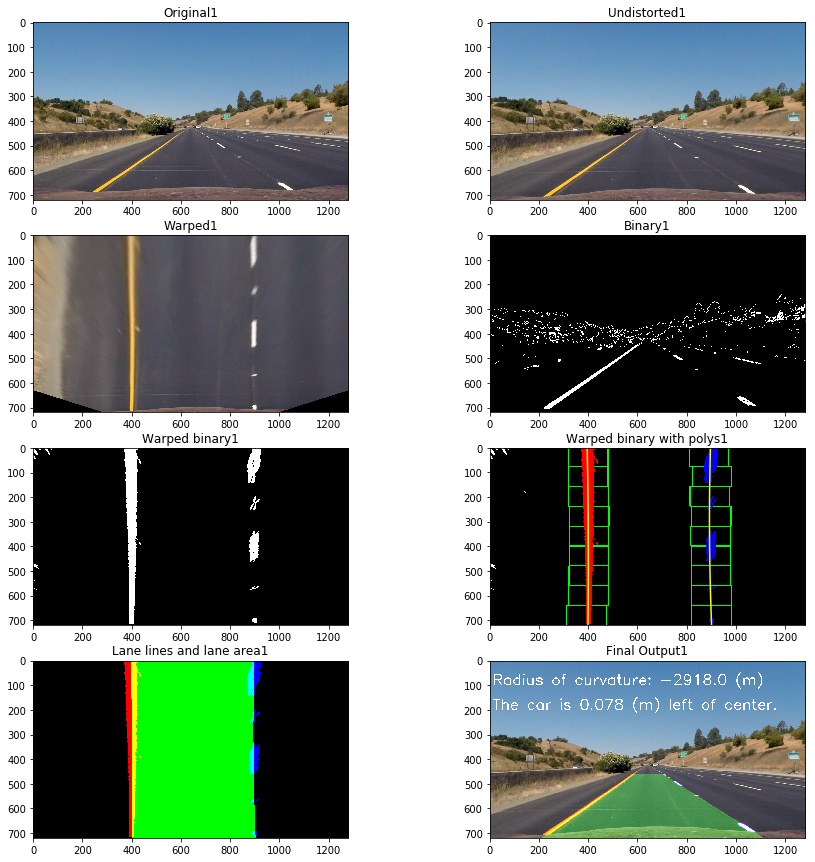

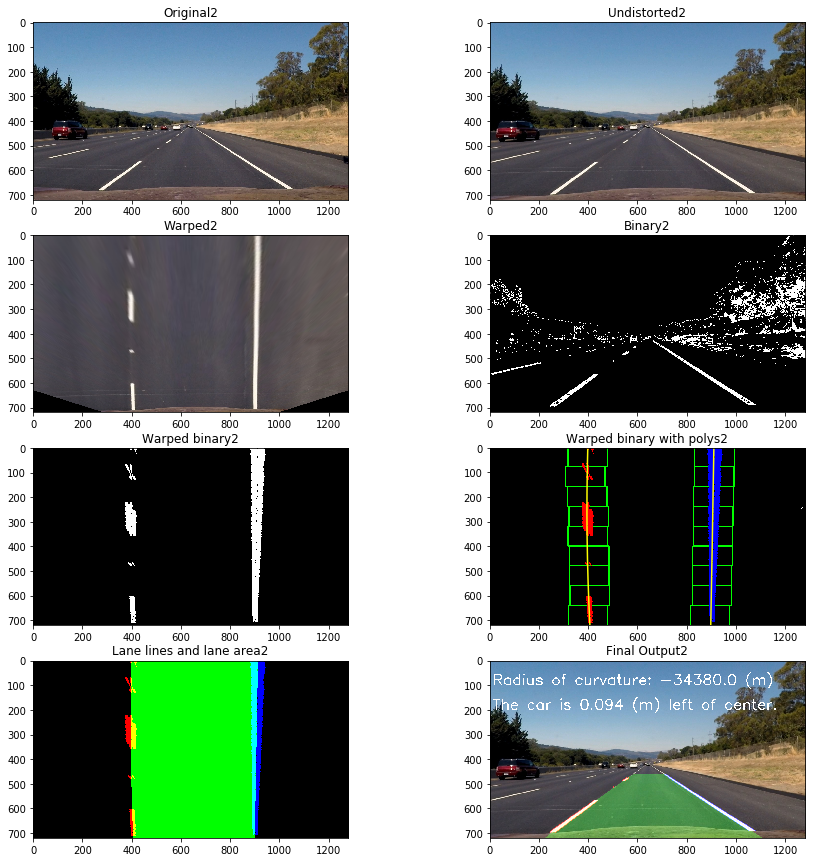

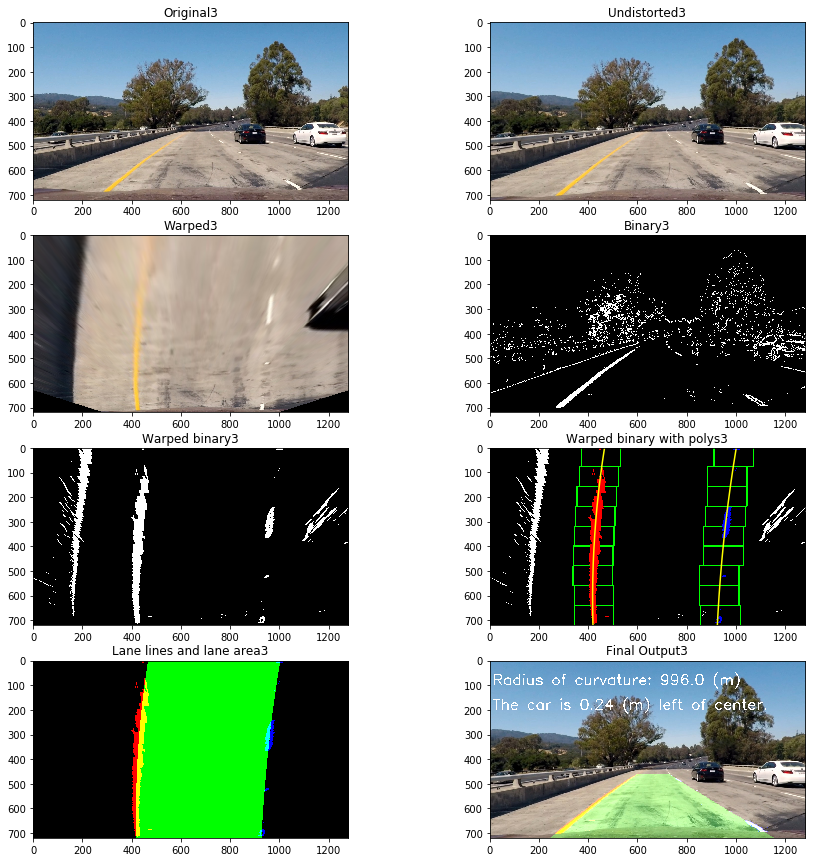

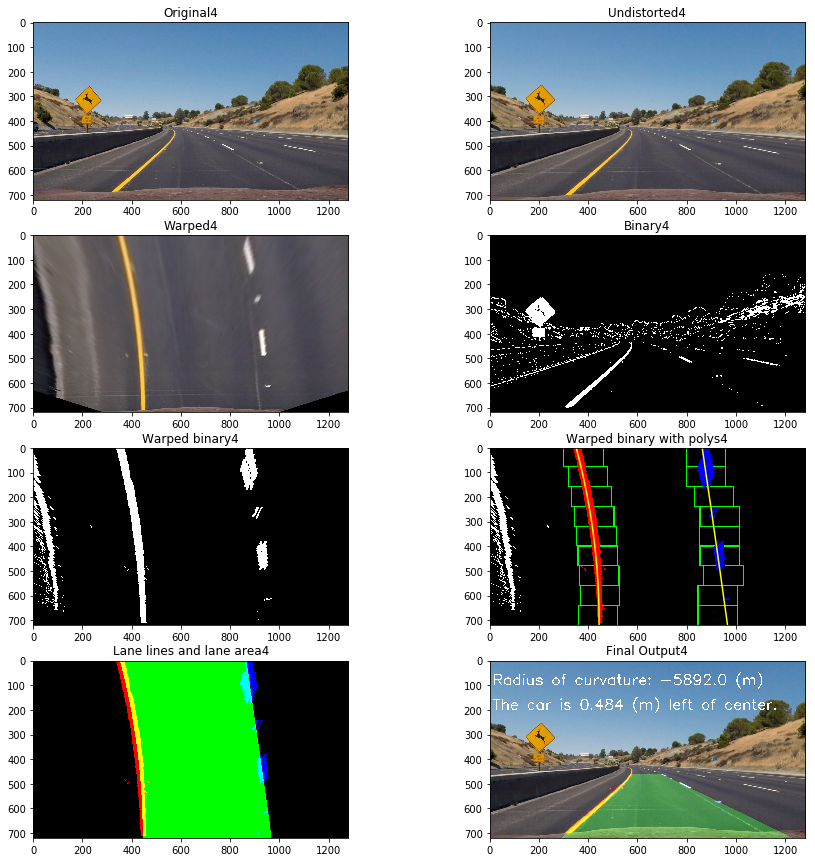

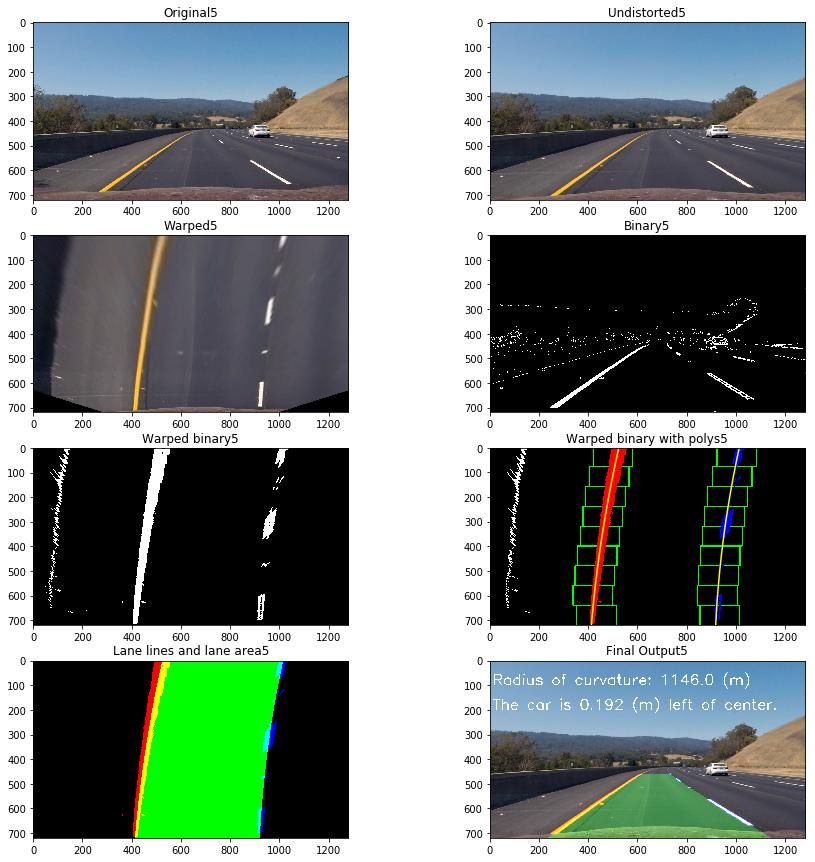

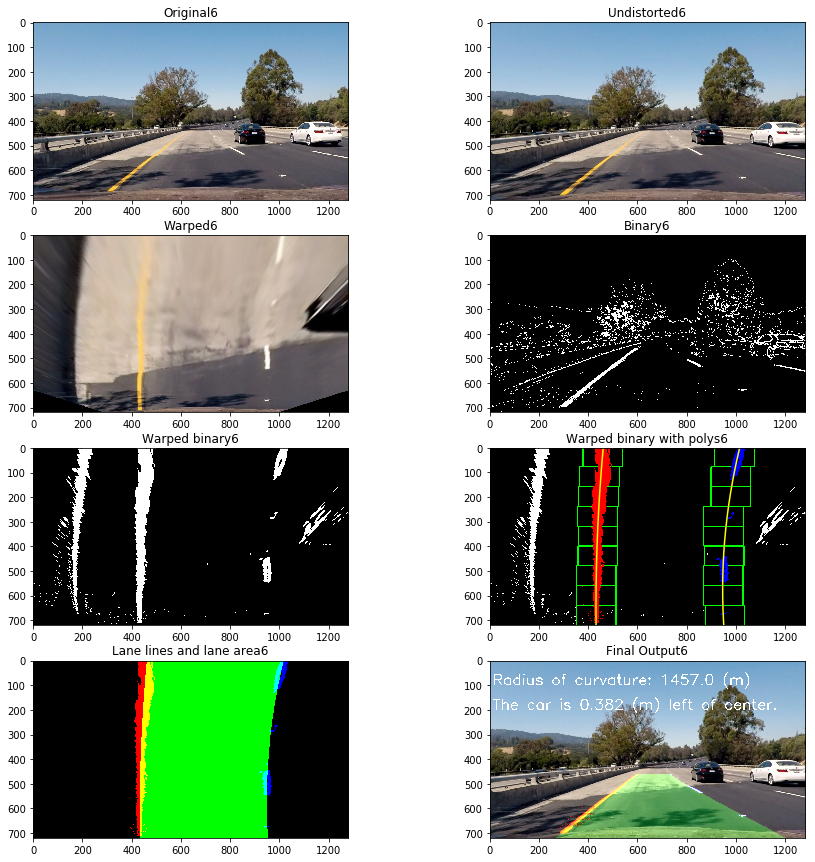

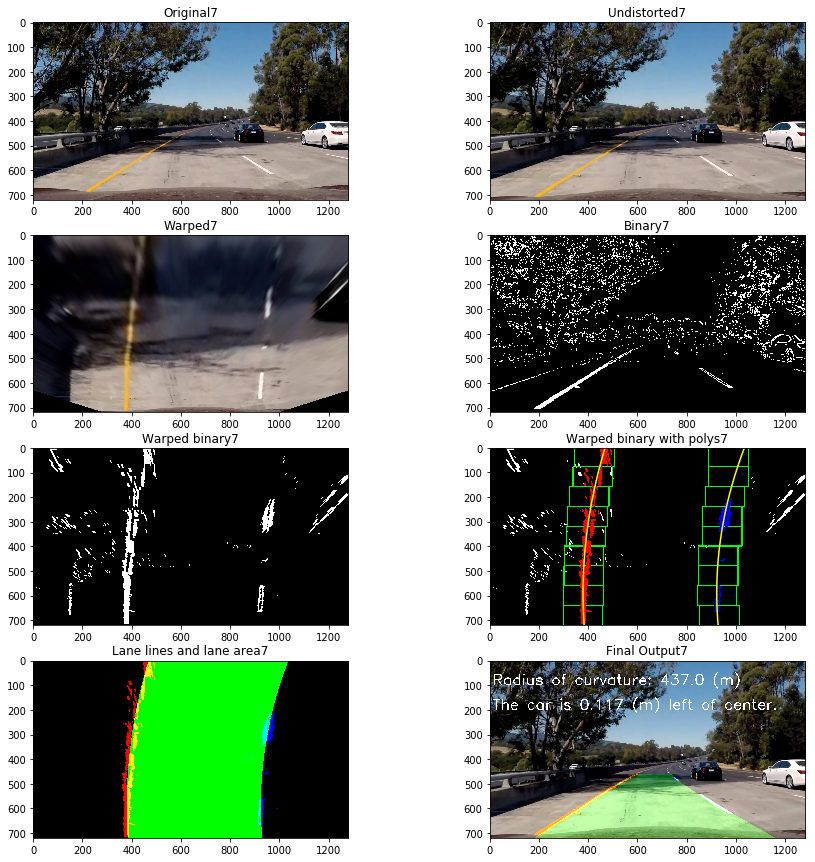

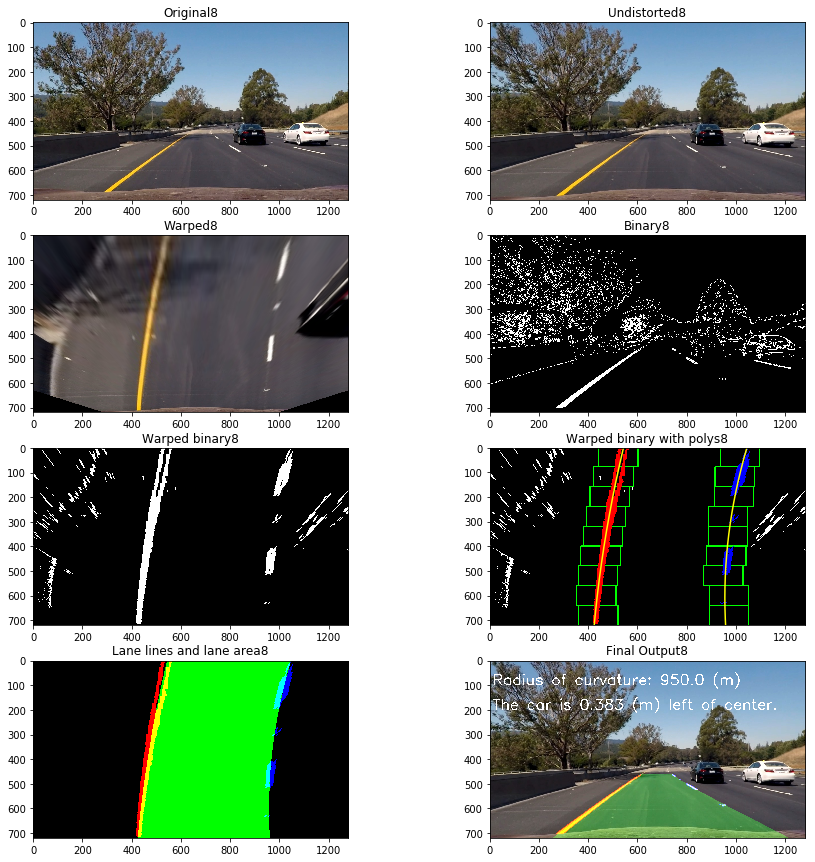

In [3]:
test_images = glob.glob('./test_images/straight_lines*.jpg') + glob.glob('./test_images/test*.jpg')
n_img = len(test_images)

for i in range(n_img):
#     print("\n", i+1,":")
    im_name = test_images[i]
    image = mpimg.imread(im_name)
    undist_img = undist(image)
    warped_img = warp(undist_img)
    thresh_img = thresholds(undist_img)
    binary_warped = warp(thresh_img)
    leftx, lefty, rightx, righty, poly_img = detect_lane_pixels(binary_warped)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = eval_poly(ploty, fit_poly(leftx, lefty))
    right_fitx = eval_poly(ploty, fit_poly(rightx, righty))
    color_warp, line_color_warp = fill_poly(binary_warped, left_fitx, right_fitx, ploty, lefty, leftx, righty, rightx)
#     out_img = find_lanes(image)
    out_img = cv2.addWeighted(cv2.addWeighted(undist_img, 1, unwarp(color_warp), 0.3, 0), 1, unwarp(line_color_warp), 1, 0)
    
    # plot images
    plt.figure(figsize=(15,15))
    plt.subplot(4,2,1)
    plt.imshow(image)
    plt.title('Original' + str(i+1))
    plt.subplot(4,2,2)
    plt.imshow(undist_img)
    plt.title('Undistorted' + str(i+1))
    plt.subplot(4,2,3)
    plt.imshow(warped_img)
    plt.title('Warped' + str(i+1))
    plt.subplot(4,2,4)
    plt.imshow(thresh_img, cmap='gray')
    plt.title('Binary' + str(i+1))
    plt.subplot(4,2,5)
    plt.imshow(binary_warped, cmap='gray')
    plt.title('Warped binary' + str(i+1))
    plt.subplot(4,2,6)
    plt.imshow(poly_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.title('Warped binary with polys' + str(i+1))
    plt.subplot(4,2,7)
    plt.imshow(cv2.addWeighted(color_warp, 1, line_color_warp, 1, 0))
    plt.title('Lane lines and lane area' + str(i+1))
    plt.subplot(4,2,8)
    plt.imshow(out_img)
    plt.title('Final Output' + str(i+1))

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [5]:
project_video_output = './output_videos/output_project_video.mp4'

clip1 = VideoFileClip("./project_video.mp4")
project_clip = clip1.fl_image(find_lanes) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video ./output_videos/output_project_video.mp4
[MoviePy] Writing video ./output_videos/output_project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:50<00:00,  4.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/output_project_video.mp4 

Wall time: 4min 52s


In [6]:
challenge_video_output = './output_videos/output_challenge_video.mp4'

clip2 = VideoFileClip("./challenge_video.mp4")
challenge_clip = clip2.fl_image(find_lanes) #NOTE: this function expects color images!!
%time challenge_clip.write_videofile(challenge_video_output, audio=False)

[MoviePy] >>>> Building video ./output_videos/output_challenge_video.mp4
[MoviePy] Writing video ./output_videos/output_challenge_video.mp4


100%|█████████████████████████████████████████| 485/485 [01:46<00:00,  4.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/output_challenge_video.mp4 

Wall time: 1min 48s


In [7]:
harder_challenge_video_output = './output_videos/output_harder_challenge_video.mp4'

clip3 = VideoFileClip("./harder_challenge_video.mp4")
harder_challenge_clip = clip3.fl_image(find_lanes) #NOTE: this function expects color images!!
%time harder_challenge_clip.write_videofile(harder_challenge_video_output, audio=False)

[MoviePy] >>>> Building video ./output_videos/output_harder_challenge_video.mp4
[MoviePy] Writing video ./output_videos/output_harder_challenge_video.mp4


100%|██████████████████████████████████████▉| 1199/1200 [05:04<00:00,  4.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/output_harder_challenge_video.mp4 

Wall time: 5min 6s
